In [1]:
import librosa
import matplotlib as mpl
import numpy as np
import random
import rosbag
import struct
import tams_pr2_guzheng
import tams_pr2_guzheng.utils as utils
import pandas as pd
import seaborn as sns

from collections import Counter
from glob import glob
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from tams_pr2_guzheng.paths import RuckigPath
from IPython import display
from tqdm.auto import tqdm
#mpl.style.use('seaborn-v0_8')

%load_ext autoreload
%autoreload 1
import sys
if '../utils' not in sys.path:
    sys.path.append('../utils')
import u
%aimport u
%aimport tams_pr2_guzheng.utils

# helpers & setup

In [2]:
def slice_animation(*, data, grid, slice_var, plot_x, plot_y, time_per_slice= 150):
    fig, ax = plt.subplots()
    palette = sns.color_palette("icefire", as_cmap=True)
    sm = plt.cm.ScalarMappable(
        cmap= palette,
        norm=mpl.colors.Normalize()
        )
    fig.colorbar(sm, ax = ax).set_label('distance to slice')

    slices = grid[slice_var].unique()
    slice_thickness = 3*np.ptp(slices)/len(slices)

    if len(plot_y) == 3:
        plot_y_data, plot_y_pred_mean, plot_y_pred_std = plot_y
    else:
        plot_y_data, plot_y_pred_mean = plot_y
        plot_y_pred_std = None

    def animate(i):
        ax.clear()
        ax.set_title(f'{slice_var} = {slices[i]:.4f}')
        grid_slice = grid[grid[slice_var] == slices[i]]
        if plot_y_pred_std is None:
            sns.lineplot(x=grid_slice[plot_x], y= grid_slice[plot_y_pred_mean].rename(plot_y_data), estimator= None, ax= ax)
        else:
            utils.plot_mean_std(grid_slice[plot_x], grid_slice[plot_y_pred_mean].rename(plot_y_data), grid_slice[plot_y_pred_std], ax= ax)
        ax.set_xlim(grid[plot_x].min(), grid[plot_x].max())
        eps= data[plot_y_data].values.ptp()/10
        
        if plot_y_pred_std is None:
            pred_lim_min = (grid[plot_y_pred_mean]).min()
            pred_lim_max = (grid[plot_y_pred_mean]).max()
        else:
            pred_lim_min = (grid[plot_y_pred_mean]-grid[plot_y_pred_std]).min()
            pred_lim_max = (grid[plot_y_pred_mean]+grid[plot_y_pred_std]).max()
        
        ax.set_ylim(
            min((pred_lim_min, data[plot_y_data].min()-eps)),
            max((pred_lim_max, data[plot_y_data].max()+eps))
        )

        distance_to_slice = data[slice_var]-slices[i]
        selection_mask = np.abs(distance_to_slice) <= slice_thickness
        spread = np.max(np.abs(distance_to_slice[selection_mask]))
        sm.norm = mpl.colors.Normalize(-spread, spread)
        sns.scatterplot(
            data= data[selection_mask],
            x= plot_x,
            y= plot_y_data,
            hue= distance_to_slice[selection_mask].rename('distance to slice'),
            hue_norm= sm.norm,
            palette= palette if selection_mask.any() else None,
            ax= ax,
            legend= False
        )
        return ax

    anim = FuncAnimation(fig, animate, frames= len(slices), interval= time_per_slice)
    plt.close(fig)
    return anim

In [3]:
def scatter_cbar(*, data, x, y, hue, hue_norm= None, cmap= None, ax= None):
    if ax is None:
        ax = plt.gca()
    if hue_norm is None:
        hue_norm = mpl.colors.Normalize()
    if cmap is None:
        cmap = sns.color_palette('ch:', as_cmap= True)
    x = data[x] if type(x) == str else x
    y = data[y] if type(y) == str else y
    hue = data[hue] if type(hue) == str else hue
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=hue_norm)
    sns.scatterplot(
        data= data,
        x= x,
        y= y,
        hue= hue,
        hue_norm= sm.norm,
        palette= cmap if data.size > 0 else None,
        legend= False,
        ax = ax)
    cbar = ax.figure.colorbar(sm, ax = ax)
    if hasattr(hue, 'name'):
        cbar.set_label(hue.name)

In [4]:
D_FILE= 'plucks_explore_fis4_outwards.json'
D_FILE= 'plucks_explore_d4_2_outwards.json'
D_FILE= 'plucks_explore_b3_3_inwards.json'
D_FILE= 'plucks_explore_b3_3_outwards.json'

D_FILE= 'plucks_explore.json'

D_FILE='plucks_explore_a4_outwards.json'
# D_FILE='plucks_explore_a4_inwards_undetected_overtones_from_b4_above.json'
# D_FILE='plucks_explore_d6_outwards.json'
# D_FILE='plucks_explore_d6_out.json'
FOLDER='/home/v4hn/ros/one/guzheng/data/active_valid_exploration/20230831'

# D_FILE='plucks_explore_d6_outwards_20230906.json'
# D_FILE='plucks_explore_d6_inwards_20230906.json'
# D_FILE='plucks_explore_d5_inwards_20230906.json'
# # D_FILE='plucks_explore_d4_inwards_20230906.json'

# # FOLDER = '/homeL/pr2admin/pr2/michael/guzheng/src/tams_pr2_guzheng/data'
# FOLDER = '/home/v4hn/ros/one/guzheng/data/active_valid_exploration/20230906 multiple strings'


D_FILE = 'plucks_explore_fis4_inwards_20230907155117.json'
FOLDER = '/home/v4hn/ros/one/guzheng/data/active_valid_exploration/20230907 five repetitions'

In [5]:
# special loading code to merge recordings
FOLDER = '/home/v4hn/ros/one/guzheng/data/active_valid_exploration/20230907 five repetitions'

D = pd.DataFrame()
for f in glob(f'{FOLDER}/*.json'):
    Df = pd.read_json(f)
    D = pd.concat((D, Df), ignore_index= True)
DF= D[['string','keypoint_pos_y', 'string_position', 'detected_note', 'loudness', 'unexpected_onsets', 'min_distance', 'neighborhood_context']].copy()

print(D.columns)
D_NAME = FOLDER.split('/')[-1]

Index(['string', 'max_vel_y', 'max_vel_z', 'max_acc_y', 'max_acc_z',
       'max_jerk_y', 'max_jerk_z', 'pre_y', 'pre_z', 'post_y', 'post_z',
       'keypoint_pos_y', 'keypoint_pos_z', 'keypoint_vel_y', 'keypoint_vel_z',
       'string_position', 'finger', 'loudness', 'detected_note', 'onset_cnt',
       'onsets', 'unexpected_onsets', 'neighborhood_context', 'min_distance'],
      dtype='object')


In [7]:
D_NAME= D_FILE.split('.')[0]
D= pd.read_json(f'{FOLDER}/{D_FILE}')
#D= pd.read_json('/homeL/pr2admin/pr2/michael/guzheng/src/tams_pr2_guzheng/data/plucks_explore_b3_3_inwards.json')
DF= D[['string','keypoint_pos_y', 'string_position', 'detected_note', 'loudness', 'unexpected_onsets', 'min_distance', 'neighborhood_context']].copy()

print(D.columns)
DF.describe()

Index(['string', 'max_vel_y', 'max_vel_z', 'max_acc_y', 'max_acc_z',
       'max_jerk_y', 'max_jerk_z', 'pre_y', 'pre_z', 'post_y', 'post_z',
       'keypoint_pos_y', 'keypoint_pos_z', 'keypoint_vel_y', 'keypoint_vel_z',
       'string_position', 'finger', 'loudness', 'detected_note', 'onset_cnt',
       'onsets', 'unexpected_onsets', 'neighborhood_context', 'min_distance'],
      dtype='object')


,keypoint_pos_y,string_position,loudness,unexpected_onsets,min_distance,neighborhood_context
count,299.000000,299.000000,249.000000,299.000000,0.0,299.000000
mean,0.002997,0.153976,51.997235,0.026756,NaN,170.654110
std,0.003981,0.104234,6.435926,0.161640,NaN,83.363068
min,-0.006803,0.000055,28.171894,0.000000,NaN,0.000000
25%,-0.000297,0.059151,48.055050,0.000000,NaN,154.845222
50%,0.003148,0.150513,53.202396,0.000000,NaN,206.545242
75%,0.006349,0.242966,57.133835,0.000000,NaN,225.343529
max,0.010597,0.336798,62.009937,1.000000,NaN,258.551819


In [6]:
# prepare actionspace and grid

# this should not be necessary, but for some reason it can happen? (maybe when failed record the trajectory?)
# fails if min_distance is not available at all (only one string known)
# DF = DF[DF['min_distance'].notna()].copy()

DL = DF[DF['loudness'].notna()].copy()  # all samples without onset are nan

string_len = DF['string_position'].max()

if (D['pre_y'] < 0.0).any():
    keypoint_pos_y_limits = np.array((-0.01, 0.018))
else:
    keypoint_pos_y_limits = np.array((-0.018, 0.01))

actionspace = RuckigPath.ActionSpace(
    string_position= np.array((0.0, string_len)),
    keypoint_pos_y= keypoint_pos_y_limits,
    keypoint_pos_z= np.array((-0.004,)),
    keypoint_vel_y= np.array((0.015,)),
    keypoint_vel_z= np.array((0.015,)),
)

features_norm_params = (
    np.array([actionspace.string_position[1]/2, (actionspace.keypoint_pos_y[0] + (actionspace.keypoint_pos_y[1]-actionspace.keypoint_pos_y[0])/2) ]),
    np.array([actionspace.string_position[1]/4, (actionspace.keypoint_pos_y[1] - actionspace.keypoint_pos_y[0])/4])
)

grid_size = 500
GridPoints = utils.make_grid_points(actionspace, grid_size)
GridPred= pd.DataFrame()

# loudness

In [42]:
features = DL[['string_position', 'keypoint_pos_y']]
value = DL['loudness'] #.fillna(0.0)

gp_loudness = utils.fit_gp_loudness(
    utils.normalize(features, features_norm_params),
    value,
)
print(f"fit scale params: {gp_loudness.kernel_.k2.get_params()}")

DF['loudness_pred'], DF['loudness_std'] = gp_loudness.predict(utils.normalize(DF[['string_position', 'keypoint_pos_y']].values, features_norm_params), return_std= True)

GridPred['mean'], GridPred['std'] = gp_loudness.predict(utils.normalize(GridPoints.values, features_norm_params), return_std= True)
Grid = GridPoints.merge(GridPred, left_index= True, right_index= True)

fit scale params: {'length_scale': (2.1, 1.0), 'length_scale_bounds': 'fixed'}


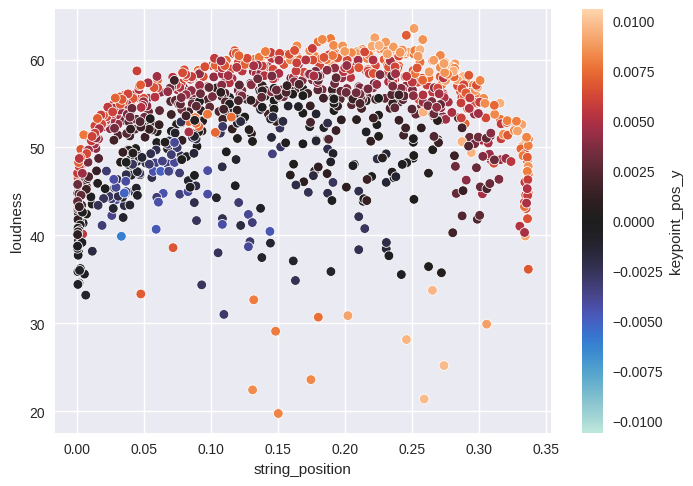

In [8]:
hue= 'keypoint_pos_y'
hue_spread = DF[hue].abs().max()
scatter_cbar(
    data= DF,
    x= 'string_position',
    y= 'loudness',
    hue= 'keypoint_pos_y', 
    cmap=sns.color_palette('icefire', as_cmap=True),
    hue_norm= plt.Normalize(-hue_spread, hue_spread)
)
u.save_plot(f'loudness overview {D_NAME}')

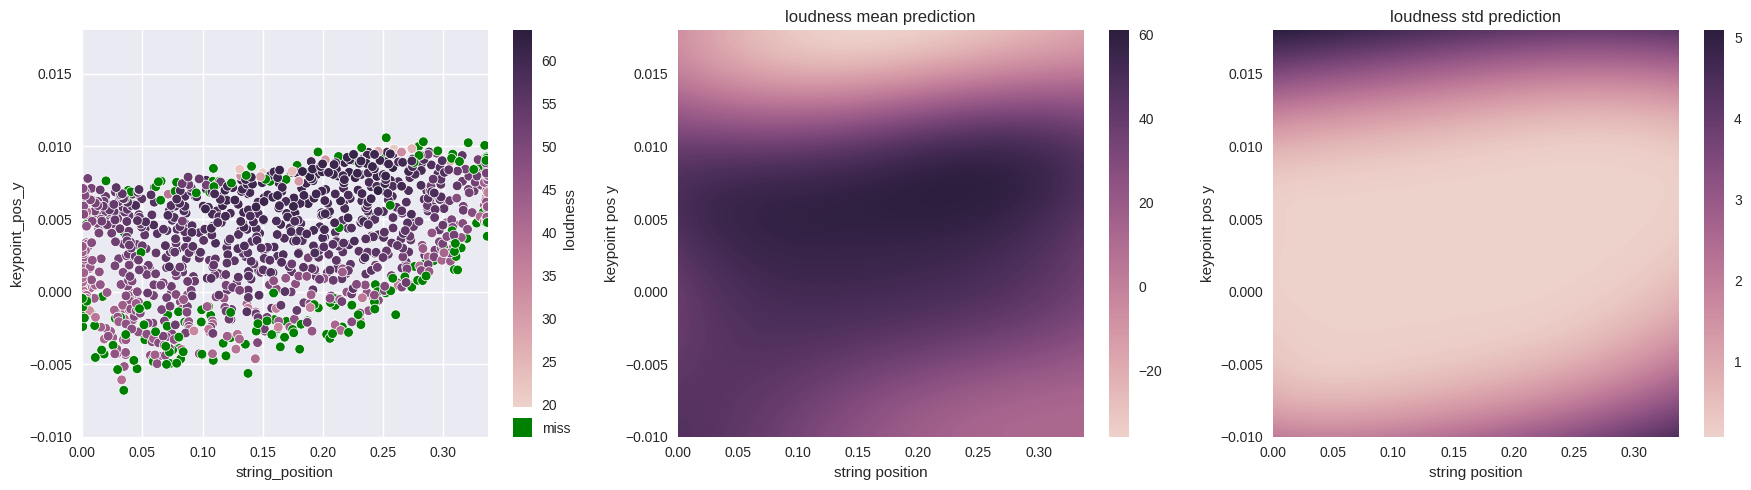

In [9]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
cmap= sns.cubehelix_palette(as_cmap=True)
utils.plot_trials(DF, DF['loudness'], ax= ax[0], actionspace= actionspace)
utils.grid_plot(GridPred['mean'], actionspace, cmap= cmap, ax= ax[1])
ax[1].set_title('loudness mean prediction')
utils.grid_plot(GridPred['std'], actionspace, cmap= cmap, ax= ax[2])
ax[2].set_title('loudness std prediction');
fig.tight_layout()
u.save_plot(f'{D_NAME} loudness prediction')

In [ ]:
# slice animations
a= slice_animation(
    data= DL,
    grid= Grid,
    slice_var= 'keypoint_pos_y',
    plot_x= 'string_position',
    plot_y= ('loudness', 'mean', 'std')
)
display.display(u.save_anim(a, f'loudness prediction slice along keypoint_pos_y {D_NAME}'))
a= slice_animation(
    data= DL,
    grid= Grid,
    slice_var= 'string_position',
    plot_x= 'keypoint_pos_y',
    plot_y= ('loudness', 'mean', 'std')
)
display.display(u.save_anim(a, f'loudness prediction slice along string position {D_NAME}'))

# validity

In [12]:
DF['validity_score'] = utils.score_validity(DF)

In [13]:
DFFull = DF.copy()

In [14]:
DF = DFFull.copy()

In [43]:
DF = DFFull.copy()
#DF = DF.iloc[:1]
gp_validity = utils.fit_gp_validity(
    utils.normalize(DF[['string_position', 'keypoint_pos_y']], features_norm_params),
    DF['validity_score'].values,
)

DF['p_validity'] = utils.prob_gt_zero(gp_validity.predict(utils.normalize(DF[['string_position', 'keypoint_pos_y']].values, features_norm_params), return_std= True))

GridPred['validity_mean'], GridPred['validity_std'] = gp_validity.predict(utils.normalize(GridPoints.values, features_norm_params), return_std= True)
Grid = GridPoints.merge(GridPred, left_index= True, right_index= True)

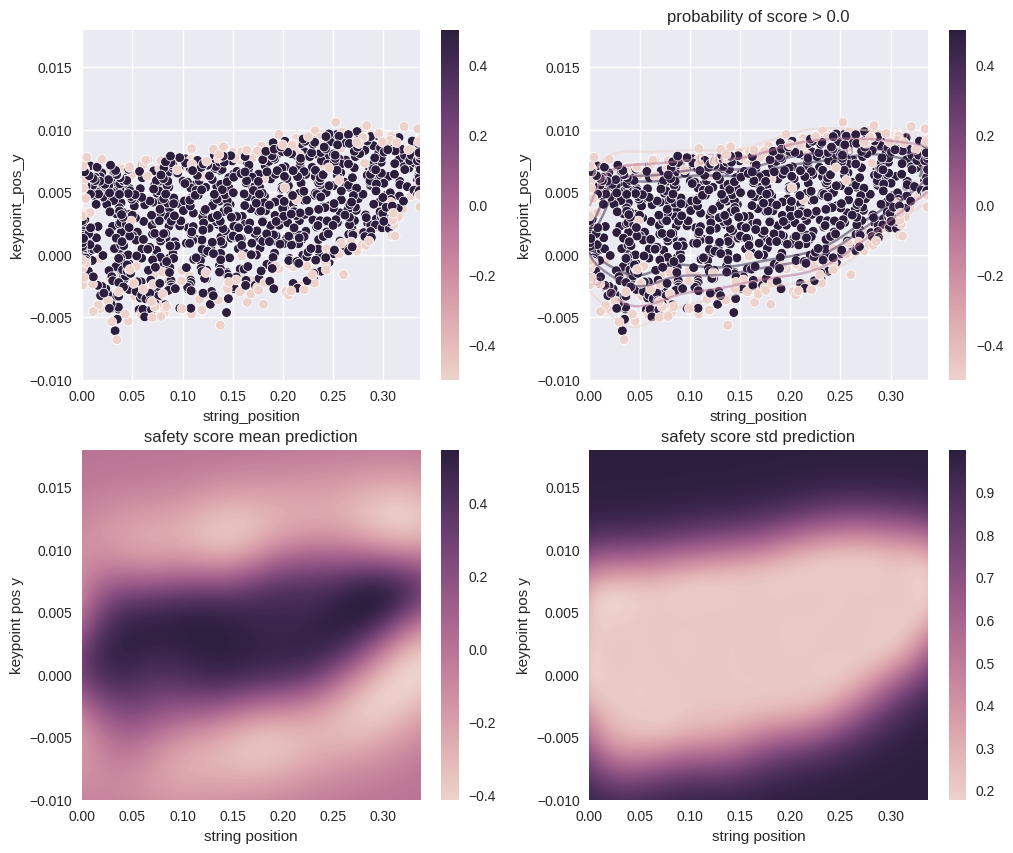

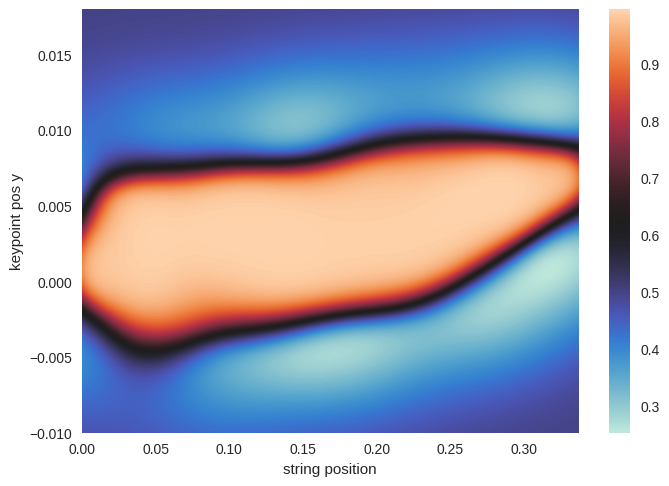

In [44]:
# plots
fig, ax = plt.subplots(2,2, figsize=(12,10))
ax = ax.ravel()
cmap= sns.cubehelix_palette(as_cmap=True)
utils.plot_trials(DF, DF['validity_score'], ax= ax[0], actionspace= actionspace)
utils.grid_plot(GridPred['validity_mean'], actionspace, cmap= cmap, ax= ax[2])
ax[2].set_title('validity score mean prediction')
utils.grid_plot(GridPred['validity_std'], actionspace, cmap= cmap, ax= ax[3])
ax[3].set_title('validity score std prediction');

Grid['p_validity'] = utils.prob_gt_zero(GridPred[['validity_mean', 'validity_std']].values.T)
# cmap = sns.color_palette('viridis', as_cmap= True)
# utils.grid_plot(Grid['p_validity'], actionspace, cmap= cmap, ax= ax[1])

utils.plot_trials(DF, DF['validity_score'], ax= ax[1], actionspace= actionspace)

# print(f"max probability of validity: {Grid['p_validity'].max():.4f}")
levels= [l for l in [0.5, 0.7, 0.9, 0.95] if l < Grid['p_validity'].max()]
con = ax[1].contour(
    Grid['string_position'].values.reshape(grid_size, grid_size),
    Grid['keypoint_pos_y'].values.reshape(grid_size,grid_size),
    Grid['p_validity'].values.reshape(grid_size,grid_size),
    levels= levels,
    cmap= cmap,
    alpha= 0.5
)
ax[1].clabel(con, inline=1, fontsize=10)
ax[1].set_title('probability of score > 0.0');
u.save_plot(f'validity prediction {D_NAME}')

plt.figure()
utils.grid_plot(Grid['p_validity'], actionspace, cmap= sns.color_palette('icefire', as_cmap= True))
u.save_plot(f'validity prediction heatmap {D_NAME}')

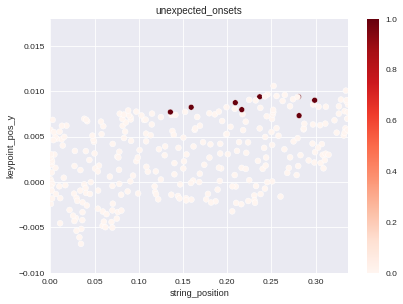

In [21]:
plt.figure(dpi= 60)
utils.plot_trials(DF, DF['unexpected_onsets'], actionspace= actionspace, cmap = sns.color_palette('Reds', as_cmap= True))
u.save_plot(f'unexpected onsets {D_NAME}')

In [22]:
# look for specific unexpected onsets log
x = D[D['min_distance'].notna()][
    ((DF['string_position'] - 0.15).abs() < 0.03) &
    (DF['unexpected_onsets'] > 0)
]
for r in x['onsets']:
    print("\n===\n")
    print(r)
# utils.plot_trials(x, x['unexpected_onsets'], actionspace= actionspace, cmap = sns.color_palette('icefire', as_cmap= True))

/tmp/ipykernel_308522/1160014403.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = D[D['min_distance'].notna()][


In [105]:
a = slice_animation(slice_var= 'keypoint_pos_y', plot_x= 'string_position', plot_y= ('validity_score', 'validity_mean', 'validity_std'),
                    data= DF,
                    grid= Grid,
)
u.save_anim(a, f'validity score prediction slice along keypoint_pos_y {D_NAME}')

In [66]:
# animate predicted p_validity and validity_score of samples
_DF = DF.copy()
_DF['validity_score'] += 0.5
a = slice_animation(slice_var= 'string_position', plot_x= 'keypoint_pos_y', plot_y= ('validity_score', 'p_validity'),
    data= _DF,
    grid= Grid,
)
u.save_anim(a, f'p_valid slice along string_position {D_NAME}')

mean: -0.0049, std: 3.2192


/home/v4hn/ros/one/guzheng/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


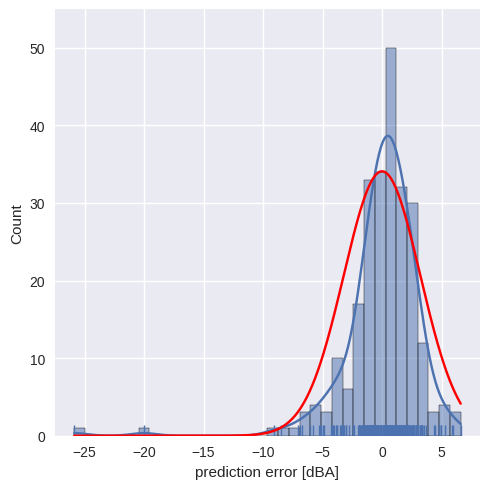

In [107]:
error = (DF['loudness']-DF['loudness_pred']).rename('prediction error [dBA]').dropna()

from scipy.stats import norm
mean, std = norm.fit(error)

print(f"mean: {mean:.4f}, std: {std:.4f}")

gridplot = sns.displot(error, kde= True, rug= True)
# plot gaussian fit with probability as right y axis
ax2 = gridplot.ax.twinx()
ax2.grid(False)
x = np.linspace(error.min(), error.max(), 2000)
ax2.plot(x, norm.pdf(x, mean, std), color= 'red');
ax2.set_ylim(0, 0.2)
ax2.set_yticklabels([]);
# ax2.set_ylabel('Gaussian Fit')
u.save_plot(f'loudness prediction error distribution {D_NAME}')

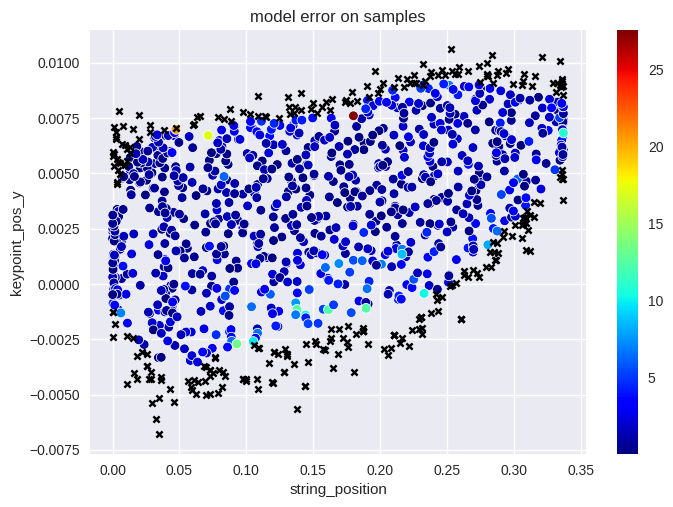

In [45]:
p_threshold_valid = 0.75
pred_error_threshold = 3.0

PredError = (DF['loudness']-DF['loudness_pred']).abs()

Unvalid = DF[(DF['p_validity'] < p_threshold_valid)]
Safe = DF[(DF['p_validity'] >= p_threshold_valid)]

WellExplained = Safe[((Safe['loudness']-Safe['loudness_pred']).abs() < pred_error_threshold)]
Outlier = Safe[~Safe.index.isin(WellExplained.index)].reset_index(drop= True)

X = DF[(DF['p_validity'] > p_threshold_valid) & (PredError < pred_error_threshold)]

notX = DF[~DF.index.isin(X.index)].reset_index(drop= True)

# loudness along string filtered by confidence
scatter_cbar(
        data= Safe,
        x= 'string_position',
        y= 'keypoint_pos_y',
        hue= np.abs(Safe['loudness']-Safe['loudness_pred']),
        cmap= plt.get_cmap('jet') #sns.color_palette('ch:2,1', as_cmap=True)
        )
plt.scatter(Unvalid['string_position'], Unvalid['keypoint_pos_y'], s=20, color= 'black', marker='x')
plt.title('model error on samples')

u.save_plot(f'loudness overview error and rejected samples {D_NAME}')

Text(0.5, 0.98, 'loudness distributions')

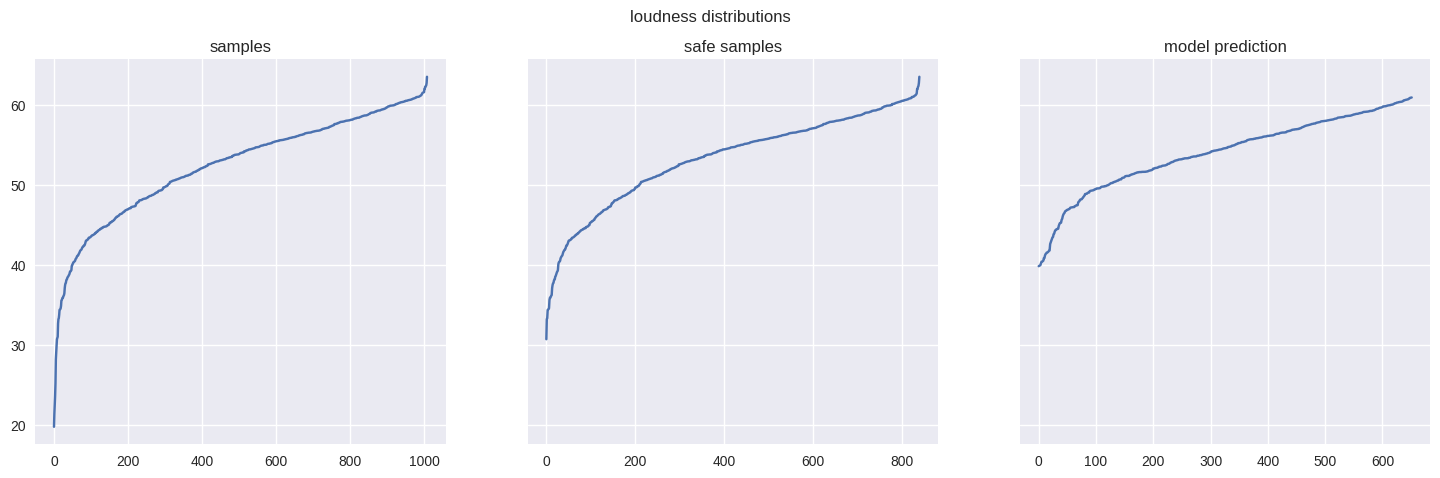

In [46]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
D['loudness'].sort_values().reset_index(drop= True).rename('sorted loudness').plot()
plt.title('samples')
plt.subplot(1,3,2, sharey= plt.gca())
DF.loc[DF['p_validity'] > 0.75, 'loudness'].sort_values().reset_index(drop= True).plot()
plt.title('valid samples')
plt.subplot(1,3,3, sharey= plt.gca())
DF.loc[DF['p_validity'] > 0.9, 'loudness_pred'].sort_values().reset_index(drop= True).plot()
plt.title('model prediction')
plt.suptitle('loudness distributions')

<Axes: >

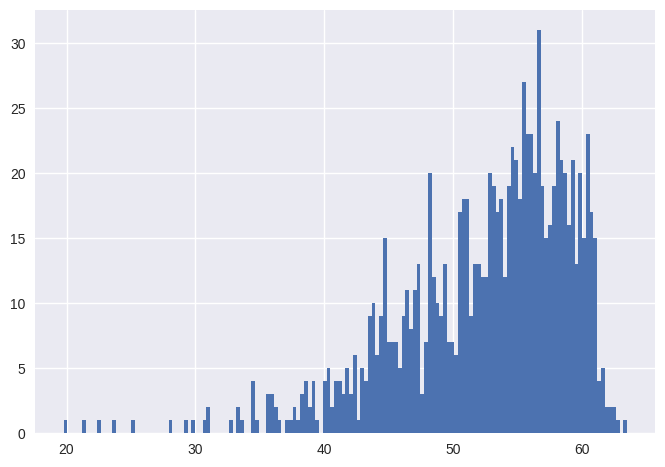

In [117]:
DF['loudness'].hist(bins= 150)

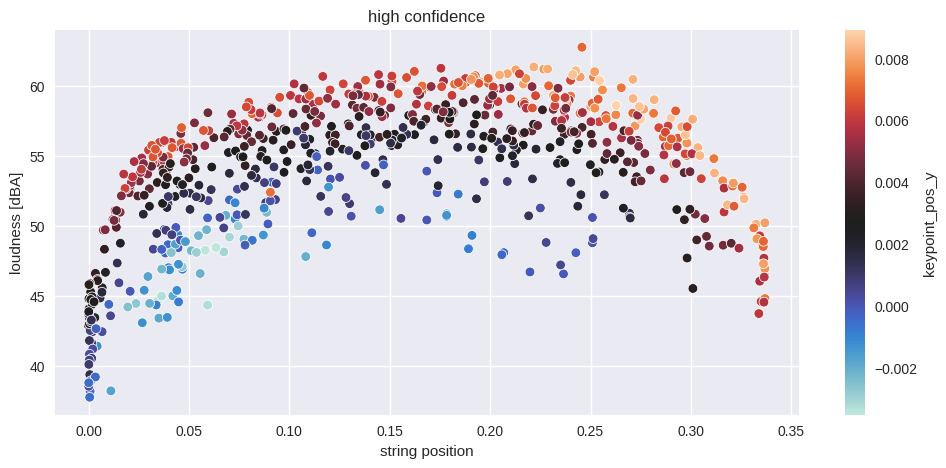

In [118]:
hue= 'keypoint_pos_y'
hue_spread = DF[hue].abs().max()
plt.figure(figsize=(12,5))
scatter_cbar(
    data= X,
    x= 'string_position',
    y= 'loudness',
    hue= 'keypoint_pos_y',
    cmap=sns.color_palette('icefire', as_cmap=True),
    #hue_norm= plt.Normalize(-hue_spread, hue_spread)
)
plt.xlabel('string position')
plt.ylabel('loudness [dBA]')
plt.title('high confidence')
u.save_plot(f'loudness overview high confidence {D_NAME}')

# incremental prediction error

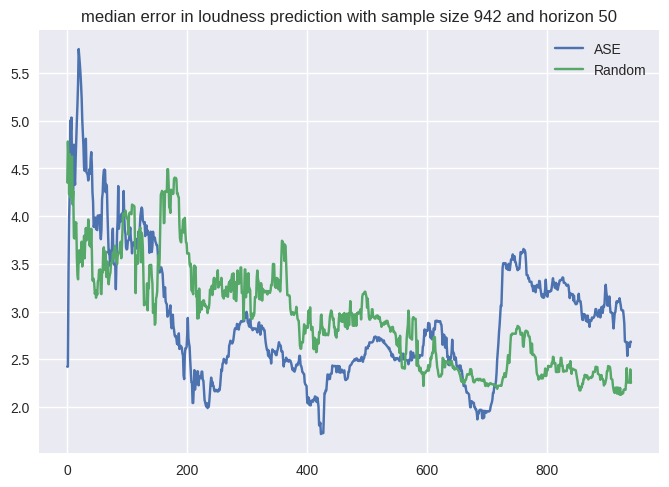

In [90]:
# sample numbers to evaluate
t = np.arange(2, len(DL))  # all
# t = np.logspace(1, np.log2(DF.dropna().size), 100, endpoint= False, base= 2).astype(int)  # in logarithmic steps

fig = plt.figure(dpi = 100)


E = np.full((t.size, 2), np.nan)

T = {
    'ASE': {
        'Samples': DL,
        'Eval': pd.DataFrame(data= E.copy(), columns= ['median', 'mean']),
    },
    'Random': {
        'Samples': DL.sample(random_state= 37, frac=1).reset_index(drop=True),
        'Eval' : pd.DataFrame(E.copy(), columns= ['median', 'mean'])
    },
}


for i in tqdm(range(t.shape[0])):
    for f in T:
        X = T[f]['Samples'][:t[i]]
        gpx_validity = utils.fit_gp_validity(
            utils.normalize(X[['string_position', 'keypoint_pos_y']], features_norm_params),
            X['validity_score'].values
        )
        
        # sample random actions from actionspace
        sample_size = 100000
        rnd = np.random.default_rng()
        # sample in domains
        domains = (
            actionspace.string_position,
            actionspace.keypoint_pos_y,
        )
        samples = rnd.uniform(0, 1, size=(sample_size, len(domains)))
        samples = np.array([p*(d[1]-d[0])+d[0] for (p,d) in zip(samples.T, domains)]).T

        sample_gpx_pvalid = utils.prob_gt_zero(gpx_validity.predict(utils.normalize(*samples, features_norm_params), return_std= True))
        sample_p_valid = utils.prob_gt_zero(gp_validity.predict(utils.normalize(*samples, features_norm_params), return_std= True))

        ((sample_gpx_pvalid > p_threshold_valid) & (sample_p_valid > p_threshold_valid)).sum() / ((sample_gpx_pvalid > p_threshold_valid) | (sample_p_valid > p_threshold_valid)).sum()


    if i % 20 != 0:
        continue
    plt.clf()
    plt.title(f'median error in loudness prediction with sample size {t[i]}')
    for f in T:
        T[f]['Eval'][['median']].rename(columns= {'median': f"{f}", 'mean' : f"{f}"}).plot(ax= plt.gca())
    # plt.xscale('log')
    plt.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close(fig)

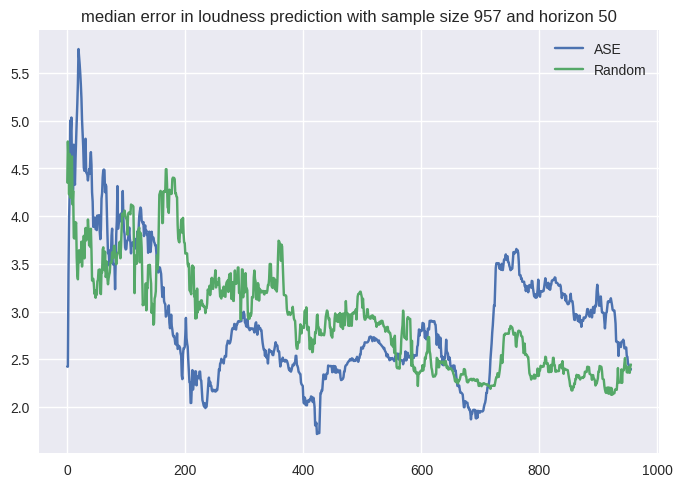

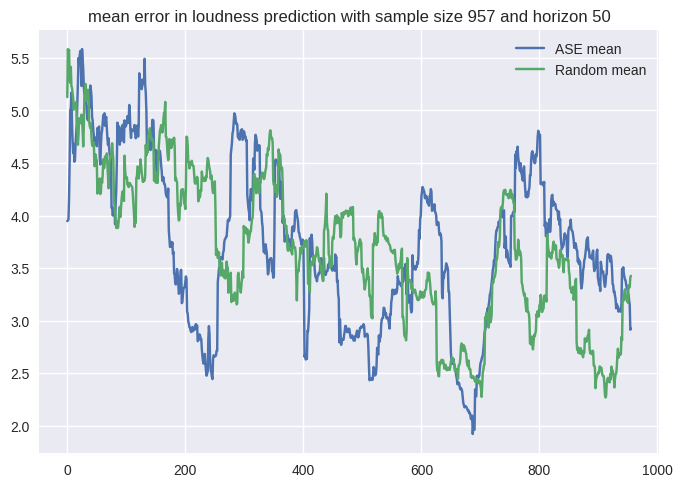

In [91]:
# final plots

for f in T:
    plt.title(f'median error in loudness prediction with sample size {t[i]} and horizon {Horizon}')
    T[f]['Eval'][['median']].rename(columns= {'median': f"{f}", 'mean' : f"{f}"}).plot(ax= plt.gca())
u.save_plot(f'median error in loudness prediction with sample size {t[i]} and horizon {Horizon} {D_NAME}')

plt.figure()
for f in T:
    plt.title(f'mean error in loudness prediction with sample size {t[i]} and horizon {Horizon}')
    T[f]['Eval'][['mean']].rename(columns= {'median': f"{f} median", 'mean' : f"{f} mean"}).plot(ax= plt.gca())
u.save_plot(f'mean error in loudness prediction with sample size {t[i]} and horizon {Horizon} {D_NAME}')

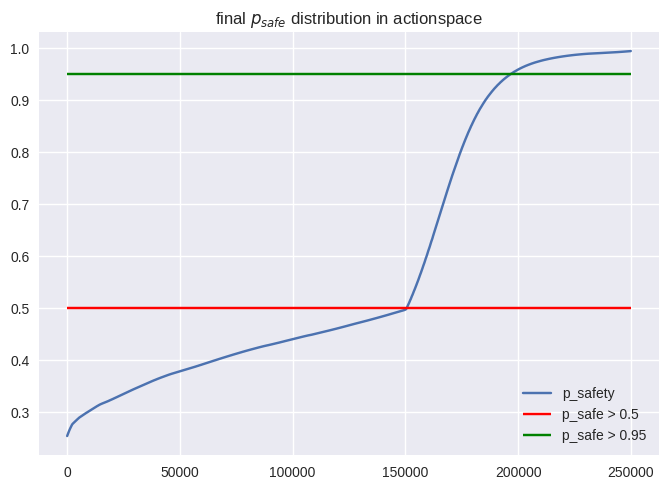

In [89]:
sns.lineplot(Grid['p_validity'].sort_values().values, label='p_validity')
plt.hlines(0.5, 0, Grid['p_validity'].size, color= 'red', label='p_valid > 0.5')
plt.hlines(0.95, 0, Grid['p_validity'].size, color= 'green', label='p_valid > 0.95')
plt.title('final $p_{valid}$ distribution in actionspace')
plt.legend(loc='lower right');

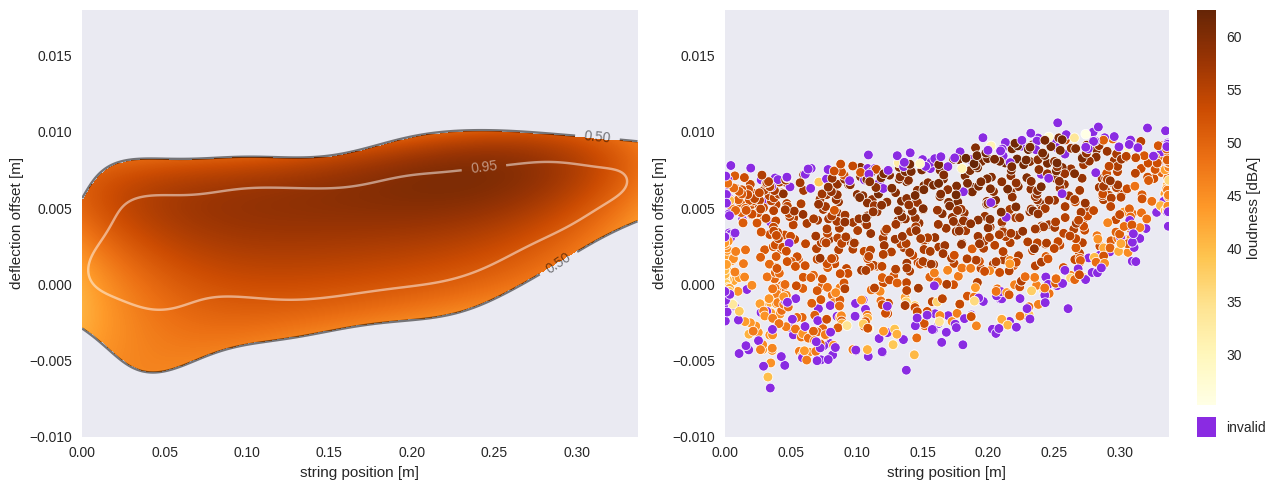

In [40]:
cmap = sns.color_palette('YlOrBr', as_cmap= True)

plt.figure(figsize=(13,5))
plt.subplot(1,2,2)

DFinvalidmasked = DF['loudness'].copy()
DFinvalidmasked[DF['validity_score'] < 0.0] = np.nan
utils.plot_trials(DF,
            DFinvalidmasked.rename('loudness [dBA]'),
            actionspace= actionspace,
            cmap = cmap,
            nan_label= 'invalid',
            nan= 'blueviolet'
            )
# set colorbar label
plt.xlabel('string position [m]')
plt.ylabel('deflection offset [m]')
plt.grid(False)

plt.subplot(1,2,1)
GridSafe = Grid[['mean', 'p_validity']].copy()
GridSafe.loc[GridSafe['p_validity'] <= 0.5,'mean'] = np.nan
utils.grid_plot(GridSafe['mean'], actionspace, cmap= cmap, vmin=DL['loudness'].min(), vmax=DL['loudness'].max(), cbar= False)
plt.xlabel('string position [m]')
plt.ylabel('deflection offset [m]')
# plt.gca().images[-1].colorbar.set_label('loudness [dBA]')

levels= [l for l in [0.5, 0.95] if l < Grid['p_validity'].max()]
con = plt.contour(
    Grid['string_position'].values.reshape(grid_size, grid_size),
    Grid['keypoint_pos_y'].values.reshape(grid_size,grid_size),
    Grid['p_validity'].values.reshape(grid_size,grid_size),
    levels= levels,
    #cmap= cmap,
    alpha= 0.5,
    colors= ['black', 'white']
)
plt.clabel(con, inline=1, fontsize=10)
#plt.suptitle('Samples and Loudness/Safety Model')
plt.tight_layout()
u.save_plot(f'loudness and validity model {D_NAME}')